In [1]:
from __future__ import print_function
import math
import torchvision.transforms as transforms
import torch
import torch.utils.data as data
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from tqdm import tqdm
from utils_BNN_resnet import neg_ELBO, Logger
from BayesianResnet import resnet18
import torchvision.models as models
from model_BNN_test import CNN_lrt
import torch.nn.functional as F
from model_SNN import Net
import matplotlib.pyplot as plt

# Helper Functions

In [2]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    #perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [3]:
def get_entropy(probabilities):
    try:
        ent = -torch.sum(probabilities.cpu() * np.log(1e-16 + probabilities.cpu()), 1)
    except:
        ent = -torch.sum(probabilities * np.log(1e-16 + probabilities))

    return ent

def get_max_entropy(probabilities):
    p_uniform = 1.0/probabilities.size(1)
    p_uniform_dist = torch.ones(probabilities.size(1))*p_uniform
    max_ent = -torch.sum(p_uniform_dist * np.log(1e-16 + p_uniform_dist))
    
    return max_ent

In [4]:
def acc_vs_eps( model, device, test_loader, epsilon):
    model.eval()
    # Accuracy counter
    correct = 0


    # Loop over all examples in test set
    for i, (data, target) in zip(tqdm(range(len(test_loader))),(test_loader)):

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)

        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)
        

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        output = model(perturbed_data)
         
        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))

    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    
    
    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [5]:
def entropy_vs_eps( model, device, test_loader, epsilon, num_samples ):
    softmax = nn.Softmax(dim=1)
    model.eval()
    # Accuracy counter
    correct = 0
    entropy = 0.0

    # Loop over all examples in test set
    #for data, target in test_loader:
    for i, (data, target) in zip(tqdm(range(len(test_loader))),(test_loader)):

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)

        # Calculate the loss
        loss = F.nll_loss(output, target)
        

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        entropy_tmp = 0.0
        for sample in range(num_samples):
            # Forward pass the data through the model
            output = model(perturbed_data)
            probs = softmax(output.data)
            entropy_tmp += get_entropy(probs)
        
        entropy += entropy_tmp/num_samples


    entropy_avg = (entropy/len(test_loader)).item()
    max_entropy = get_max_entropy(probs)
    print("Epsilon: {}\tEntropy = {}".format(epsilon, entropy_avg))
    
    
    # Return the accuracy and an adversarial example
    return entropy_avg, max_entropy

# Setup

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

learning_rate = 0.001
weight_decay = 1e-3
batch_size = 16
num_epochs = 80

In [10]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ])

In [11]:
# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=1)

Files already downloaded and verified
Files already downloaded and verified


# Frequentist Net

In [20]:
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
# Initialize the network
model = Net().to(device)

criterion=nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [21]:
frequentist_train_acc = []
frequentist_val_acc = []

for epoch in range(1, num_epochs + 1):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    m_train = math.ceil(len(train_data) / batch_size)
    m_test= math.ceil(len(test_data) / batch_size)

    total = 0
    correct = 0

    for batch_idx, (data, target) in zip(tqdm(range(m_train)),(train_loader)):
        model.train()
        # move tensors to GPU if CUDA is available
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += (loss.item() * data.size(0))

    test_correct = 0
    test_total = 0

    with torch.no_grad():
        model.eval()
        for i, (test_input, test_target) in zip(tqdm(range(m_test)), test_loader):
        # for (test_data, test_target) in test_loader:
            test_input, test_target = test_input.cuda(), test_target.cuda()
            test_outputs= model(test_input)
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_total += test_target.size(0)
            test_correct += (test_predicted == test_target).sum().item()

    train_loss = train_loss / len(train_loader.dataset)

    frequentist_train_acc.append(correct / total)
    frequentist_val_acc.append(test_correct/ test_total)
        
    print('--------------------------------------------------------------')
    print('Epoch:', epoch)
    print('--------------------------------------------------------------')
    print('Trainig loss:', train_loss)
    print('--------------------------------------------------------------')
    print('Accuracy of the network on the train images: {} percent ({}/{})'.format (
            100 * correct / total, correct, total))
    print('--------------------------------------------------------------')

    print('Accuracy of the network on the test images: {} percent ({}/{})'.format (
            100 * test_correct/ test_total, test_correct,test_total))
    print('--------------------------------------------------------------')


  0%|          | 12/3125 [00:00<00:27, 114.15it/s]

--------------------------------------------------------------
Epoch: 1
--------------------------------------------------------------
Trainig loss: 1.5212732696723938
--------------------------------------------------------------
Accuracy of the network on the train images: 45.95 percent (22975/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.08 percent (338/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:29, 105.98it/s]

--------------------------------------------------------------
Epoch: 2
--------------------------------------------------------------
Trainig loss: 1.2948866560554504
--------------------------------------------------------------
Accuracy of the network on the train images: 54.398 percent (27199/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 57.44 percent (359/625)
--------------------------------------------------------------


  0%|          | 10/3125 [00:00<00:34, 91.15it/s]

--------------------------------------------------------------
Epoch: 3
--------------------------------------------------------------
Trainig loss: 1.2230659342384338
--------------------------------------------------------------
Accuracy of the network on the train images: 57.03 percent (28515/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.0 percent (375/625)
--------------------------------------------------------------


  0%|          | 10/3125 [00:00<00:33, 92.33it/s]

--------------------------------------------------------------
Epoch: 4
--------------------------------------------------------------
Trainig loss: 1.1796399907684325
--------------------------------------------------------------
Accuracy of the network on the train images: 58.628 percent (29314/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.8 percent (380/625)
--------------------------------------------------------------


  0%|          | 10/3125 [00:00<00:31, 99.80it/s]

--------------------------------------------------------------
Epoch: 5
--------------------------------------------------------------
Trainig loss: 1.14644927110672
--------------------------------------------------------------
Accuracy of the network on the train images: 59.754 percent (29877/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.32 percent (377/625)
--------------------------------------------------------------


  0%|          | 9/3125 [00:00<00:36, 86.29it/s]

--------------------------------------------------------------
Epoch: 6
--------------------------------------------------------------
Trainig loss: 1.1190204827594756
--------------------------------------------------------------
Accuracy of the network on the train images: 60.712 percent (30356/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 61.28 percent (383/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:30, 101.88it/s]

--------------------------------------------------------------
Epoch: 7
--------------------------------------------------------------
Trainig loss: 1.095899246673584
--------------------------------------------------------------
Accuracy of the network on the train images: 61.63 percent (30815/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 61.12 percent (382/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:29, 104.15it/s]

--------------------------------------------------------------
Epoch: 8
--------------------------------------------------------------
Trainig loss: 1.0759221564483643
--------------------------------------------------------------
Accuracy of the network on the train images: 62.368 percent (31184/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.48 percent (378/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:28, 108.96it/s]

--------------------------------------------------------------
Epoch: 9
--------------------------------------------------------------
Trainig loss: 1.0587641728687287
--------------------------------------------------------------
Accuracy of the network on the train images: 62.86 percent (31430/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.8 percent (380/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:32, 96.97it/s]

--------------------------------------------------------------
Epoch: 10
--------------------------------------------------------------
Trainig loss: 1.043836641778946
--------------------------------------------------------------
Accuracy of the network on the train images: 63.406 percent (31703/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.64 percent (379/625)
--------------------------------------------------------------


  0%|          | 10/3125 [00:00<00:31, 99.82it/s]

--------------------------------------------------------------
Epoch: 11
--------------------------------------------------------------
Trainig loss: 1.0310967233753205
--------------------------------------------------------------
Accuracy of the network on the train images: 63.768 percent (31884/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.48 percent (378/625)
--------------------------------------------------------------


  0%|          | 10/3125 [00:00<00:32, 97.16it/s]

--------------------------------------------------------------
Epoch: 12
--------------------------------------------------------------
Trainig loss: 1.0198437964725495
--------------------------------------------------------------
Accuracy of the network on the train images: 64.196 percent (32098/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.48 percent (378/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:29, 106.88it/s]

--------------------------------------------------------------
Epoch: 13
--------------------------------------------------------------
Trainig loss: 1.0101681286525726
--------------------------------------------------------------
Accuracy of the network on the train images: 64.444 percent (32222/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.64 percent (379/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:29, 106.46it/s]

--------------------------------------------------------------
Epoch: 14
--------------------------------------------------------------
Trainig loss: 1.00133947681427
--------------------------------------------------------------
Accuracy of the network on the train images: 64.686 percent (32343/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.16 percent (376/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:30, 101.59it/s]

--------------------------------------------------------------
Epoch: 15
--------------------------------------------------------------
Trainig loss: 0.9932070319461822
--------------------------------------------------------------
Accuracy of the network on the train images: 65.024 percent (32512/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.96 percent (381/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:29, 107.36it/s]

--------------------------------------------------------------
Epoch: 16
--------------------------------------------------------------
Trainig loss: 0.9858991616916657
--------------------------------------------------------------
Accuracy of the network on the train images: 65.332 percent (32666/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.8 percent (380/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:29, 104.15it/s]

--------------------------------------------------------------
Epoch: 17
--------------------------------------------------------------
Trainig loss: 0.9793360140705109
--------------------------------------------------------------
Accuracy of the network on the train images: 65.658 percent (32829/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 61.12 percent (382/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:29, 106.68it/s]

--------------------------------------------------------------
Epoch: 18
--------------------------------------------------------------
Trainig loss: 0.9731172994709015
--------------------------------------------------------------
Accuracy of the network on the train images: 65.848 percent (32924/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.96 percent (381/625)
--------------------------------------------------------------


  0%|          | 10/3125 [00:00<00:31, 98.40it/s]

--------------------------------------------------------------
Epoch: 19
--------------------------------------------------------------
Trainig loss: 0.9671367286586762
--------------------------------------------------------------
Accuracy of the network on the train images: 66.06 percent (33030/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 61.76 percent (386/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:29, 106.09it/s]

--------------------------------------------------------------
Epoch: 20
--------------------------------------------------------------
Trainig loss: 0.9613955853748322
--------------------------------------------------------------
Accuracy of the network on the train images: 66.316 percent (33158/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 61.76 percent (386/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:30, 102.49it/s]

--------------------------------------------------------------
Epoch: 21
--------------------------------------------------------------
Trainig loss: 0.9560281421375275
--------------------------------------------------------------
Accuracy of the network on the train images: 66.48 percent (33240/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 61.76 percent (386/625)
--------------------------------------------------------------


  0%|          | 12/3125 [00:00<00:27, 113.25it/s]

--------------------------------------------------------------
Epoch: 22
--------------------------------------------------------------
Trainig loss: 0.9510628299331665
--------------------------------------------------------------
Accuracy of the network on the train images: 66.644 percent (33322/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 61.76 percent (386/625)
--------------------------------------------------------------


  0%|          | 10/3125 [00:00<00:32, 96.78it/s]

--------------------------------------------------------------
Epoch: 23
--------------------------------------------------------------
Trainig loss: 0.9463654723644257
--------------------------------------------------------------
Accuracy of the network on the train images: 66.83 percent (33415/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 61.92 percent (387/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:28, 108.05it/s]

--------------------------------------------------------------
Epoch: 24
--------------------------------------------------------------
Trainig loss: 0.9418991646003723
--------------------------------------------------------------
Accuracy of the network on the train images: 66.968 percent (33484/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 61.44 percent (384/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:29, 104.88it/s]

--------------------------------------------------------------
Epoch: 25
--------------------------------------------------------------
Trainig loss: 0.9378664085006714
--------------------------------------------------------------
Accuracy of the network on the train images: 67.172 percent (33586/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 61.28 percent (383/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:29, 105.92it/s]

--------------------------------------------------------------
Epoch: 26
--------------------------------------------------------------
Trainig loss: 0.9339272985935211
--------------------------------------------------------------
Accuracy of the network on the train images: 67.298 percent (33649/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 61.76 percent (386/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:29, 104.96it/s]

--------------------------------------------------------------
Epoch: 27
--------------------------------------------------------------
Trainig loss: 0.930239520072937
--------------------------------------------------------------
Accuracy of the network on the train images: 67.49 percent (33745/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 61.44 percent (384/625)
--------------------------------------------------------------


  0%|          | 9/3125 [00:00<00:34, 89.34it/s]

--------------------------------------------------------------
Epoch: 28
--------------------------------------------------------------
Trainig loss: 0.92675264544487
--------------------------------------------------------------
Accuracy of the network on the train images: 67.634 percent (33817/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.96 percent (381/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:29, 106.74it/s]

--------------------------------------------------------------
Epoch: 29
--------------------------------------------------------------
Trainig loss: 0.9235187753963471
--------------------------------------------------------------
Accuracy of the network on the train images: 67.836 percent (33918/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.96 percent (381/625)
--------------------------------------------------------------


  0%|          | 12/3125 [00:00<00:28, 110.72it/s]

--------------------------------------------------------------
Epoch: 30
--------------------------------------------------------------
Trainig loss: 0.9204489983654022
--------------------------------------------------------------
Accuracy of the network on the train images: 67.97 percent (33985/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.96 percent (381/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:29, 105.19it/s]

--------------------------------------------------------------
Epoch: 31
--------------------------------------------------------------
Trainig loss: 0.9175044200706481
--------------------------------------------------------------
Accuracy of the network on the train images: 68.044 percent (34022/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.16 percent (376/625)
--------------------------------------------------------------


  0%|          | 10/3125 [00:00<00:33, 93.52it/s]

--------------------------------------------------------------
Epoch: 32
--------------------------------------------------------------
Trainig loss: 0.9146820577526092
--------------------------------------------------------------
Accuracy of the network on the train images: 68.152 percent (34076/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.64 percent (379/625)
--------------------------------------------------------------


  0%|          | 9/3125 [00:00<00:35, 86.74it/s]

--------------------------------------------------------------
Epoch: 33
--------------------------------------------------------------
Trainig loss: 0.9120514870548249
--------------------------------------------------------------
Accuracy of the network on the train images: 68.236 percent (34118/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.64 percent (379/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:30, 103.06it/s]

--------------------------------------------------------------
Epoch: 34
--------------------------------------------------------------
Trainig loss: 0.9094588524341584
--------------------------------------------------------------
Accuracy of the network on the train images: 68.332 percent (34166/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.8 percent (380/625)
--------------------------------------------------------------


  0%|          | 10/3125 [00:00<00:32, 95.78it/s]

--------------------------------------------------------------
Epoch: 35
--------------------------------------------------------------
Trainig loss: 0.9070095196056366
--------------------------------------------------------------
Accuracy of the network on the train images: 68.404 percent (34202/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.64 percent (379/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:29, 104.08it/s]

--------------------------------------------------------------
Epoch: 36
--------------------------------------------------------------
Trainig loss: 0.9046869814395905
--------------------------------------------------------------
Accuracy of the network on the train images: 68.542 percent (34271/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.48 percent (378/625)
--------------------------------------------------------------


  0%|          | 9/3125 [00:00<00:35, 86.68it/s]

--------------------------------------------------------------
Epoch: 37
--------------------------------------------------------------
Trainig loss: 0.902390408668518
--------------------------------------------------------------
Accuracy of the network on the train images: 68.57 percent (34285/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.32 percent (377/625)
--------------------------------------------------------------


  0%|          | 9/3125 [00:00<00:39, 79.35it/s]

--------------------------------------------------------------
Epoch: 38
--------------------------------------------------------------
Trainig loss: 0.9002851930427551
--------------------------------------------------------------
Accuracy of the network on the train images: 68.692 percent (34346/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 59.84 percent (374/625)
--------------------------------------------------------------


  0%|          | 13/3125 [00:00<00:25, 120.97it/s]

--------------------------------------------------------------
Epoch: 39
--------------------------------------------------------------
Trainig loss: 0.8982987257766724
--------------------------------------------------------------
Accuracy of the network on the train images: 68.718 percent (34359/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.16 percent (376/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:29, 105.89it/s]

--------------------------------------------------------------
Epoch: 40
--------------------------------------------------------------
Trainig loss: 0.896306151342392
--------------------------------------------------------------
Accuracy of the network on the train images: 68.782 percent (34391/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 59.68 percent (373/625)
--------------------------------------------------------------


  0%|          | 12/3125 [00:00<00:25, 119.80it/s]

--------------------------------------------------------------
Epoch: 41
--------------------------------------------------------------
Trainig loss: 0.894538129620552
--------------------------------------------------------------
Accuracy of the network on the train images: 68.82 percent (34410/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 59.68 percent (373/625)
--------------------------------------------------------------


  0%|          | 9/3125 [00:00<00:35, 88.46it/s]

--------------------------------------------------------------
Epoch: 42
--------------------------------------------------------------
Trainig loss: 0.892799463005066
--------------------------------------------------------------
Accuracy of the network on the train images: 68.928 percent (34464/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 59.2 percent (370/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:30, 101.25it/s]

--------------------------------------------------------------
Epoch: 43
--------------------------------------------------------------
Trainig loss: 0.8911877760791779
--------------------------------------------------------------
Accuracy of the network on the train images: 69.008 percent (34504/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.0 percent (375/625)
--------------------------------------------------------------


  0%|          | 10/3125 [00:00<00:34, 90.36it/s]

--------------------------------------------------------------
Epoch: 44
--------------------------------------------------------------
Trainig loss: 0.8896275926589966
--------------------------------------------------------------
Accuracy of the network on the train images: 69.128 percent (34564/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 59.68 percent (373/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:30, 103.20it/s]

--------------------------------------------------------------
Epoch: 45
--------------------------------------------------------------
Trainig loss: 0.8881175814437866
--------------------------------------------------------------
Accuracy of the network on the train images: 69.2 percent (34600/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 59.04 percent (369/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:28, 108.37it/s]

--------------------------------------------------------------
Epoch: 46
--------------------------------------------------------------
Trainig loss: 0.8867354581546784
--------------------------------------------------------------
Accuracy of the network on the train images: 69.272 percent (34636/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.88 percent (368/625)
--------------------------------------------------------------


  0%|          | 10/3125 [00:00<00:31, 98.24it/s]

--------------------------------------------------------------
Epoch: 47
--------------------------------------------------------------
Trainig loss: 0.8853304799556733
--------------------------------------------------------------
Accuracy of the network on the train images: 69.33 percent (34665/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 59.04 percent (369/625)
--------------------------------------------------------------


  0%|          | 12/3125 [00:00<00:27, 113.96it/s]

--------------------------------------------------------------
Epoch: 48
--------------------------------------------------------------
Trainig loss: 0.8840382948684692
--------------------------------------------------------------
Accuracy of the network on the train images: 69.332 percent (34666/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.56 percent (366/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:29, 105.42it/s]

--------------------------------------------------------------
Epoch: 49
--------------------------------------------------------------
Trainig loss: 0.882764734363556
--------------------------------------------------------------
Accuracy of the network on the train images: 69.376 percent (34688/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.56 percent (366/625)
--------------------------------------------------------------


  0%|          | 9/3125 [00:00<00:35, 86.79it/s]

--------------------------------------------------------------
Epoch: 50
--------------------------------------------------------------
Trainig loss: 0.8815352652215958
--------------------------------------------------------------
Accuracy of the network on the train images: 69.416 percent (34708/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.4 percent (365/625)
--------------------------------------------------------------


  0%|          | 9/3125 [00:00<00:34, 89.65it/s]

--------------------------------------------------------------
Epoch: 51
--------------------------------------------------------------
Trainig loss: 0.8804285680294037
--------------------------------------------------------------
Accuracy of the network on the train images: 69.406 percent (34703/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.72 percent (367/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:30, 102.78it/s]

--------------------------------------------------------------
Epoch: 52
--------------------------------------------------------------
Trainig loss: 0.8791765683698655
--------------------------------------------------------------
Accuracy of the network on the train images: 69.49 percent (34745/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.72 percent (367/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:29, 106.38it/s]

--------------------------------------------------------------
Epoch: 53
--------------------------------------------------------------
Trainig loss: 0.8781814491558075
--------------------------------------------------------------
Accuracy of the network on the train images: 69.58 percent (34790/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.72 percent (367/625)
--------------------------------------------------------------


  0%|          | 13/3125 [00:00<00:25, 122.13it/s]

--------------------------------------------------------------
Epoch: 54
--------------------------------------------------------------
Trainig loss: 0.8772301135587692
--------------------------------------------------------------
Accuracy of the network on the train images: 69.582 percent (34791/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 59.04 percent (369/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:30, 101.53it/s]

--------------------------------------------------------------
Epoch: 55
--------------------------------------------------------------
Trainig loss: 0.8761860302209854
--------------------------------------------------------------
Accuracy of the network on the train images: 69.52 percent (34760/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 59.04 percent (369/625)
--------------------------------------------------------------


  0%|          | 12/3125 [00:00<00:28, 110.69it/s]

--------------------------------------------------------------
Epoch: 56
--------------------------------------------------------------
Trainig loss: 0.8751538533020019
--------------------------------------------------------------
Accuracy of the network on the train images: 69.616 percent (34808/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.88 percent (368/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:30, 101.35it/s]

--------------------------------------------------------------
Epoch: 57
--------------------------------------------------------------
Trainig loss: 0.8741978205394745
--------------------------------------------------------------
Accuracy of the network on the train images: 69.598 percent (34799/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 59.36 percent (371/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:29, 105.25it/s]

--------------------------------------------------------------
Epoch: 58
--------------------------------------------------------------
Trainig loss: 0.8733405153369903
--------------------------------------------------------------
Accuracy of the network on the train images: 69.654 percent (34827/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.72 percent (367/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:29, 106.11it/s]

--------------------------------------------------------------
Epoch: 59
--------------------------------------------------------------
Trainig loss: 0.8724071176242828
--------------------------------------------------------------
Accuracy of the network on the train images: 69.624 percent (34812/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 59.2 percent (370/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:30, 100.59it/s]

--------------------------------------------------------------
Epoch: 60
--------------------------------------------------------------
Trainig loss: 0.871393780965805
--------------------------------------------------------------
Accuracy of the network on the train images: 69.624 percent (34812/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.72 percent (367/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:29, 105.48it/s]

--------------------------------------------------------------
Epoch: 61
--------------------------------------------------------------
Trainig loss: 0.8705801904296875
--------------------------------------------------------------
Accuracy of the network on the train images: 69.67 percent (34835/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.72 percent (367/625)
--------------------------------------------------------------


  0%|          | 9/3125 [00:00<00:35, 88.22it/s]

--------------------------------------------------------------
Epoch: 62
--------------------------------------------------------------
Trainig loss: 0.8697724076271057
--------------------------------------------------------------
Accuracy of the network on the train images: 69.688 percent (34844/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 57.92 percent (362/625)
--------------------------------------------------------------


  0%|          | 12/3125 [00:00<00:28, 110.81it/s]

--------------------------------------------------------------
Epoch: 63
--------------------------------------------------------------
Trainig loss: 0.8689576652956009
--------------------------------------------------------------
Accuracy of the network on the train images: 69.71 percent (34855/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.08 percent (363/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:30, 101.59it/s]

--------------------------------------------------------------
Epoch: 64
--------------------------------------------------------------
Trainig loss: 0.8680376829004288
--------------------------------------------------------------
Accuracy of the network on the train images: 69.686 percent (34843/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 57.6 percent (360/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:28, 109.99it/s]

--------------------------------------------------------------
Epoch: 65
--------------------------------------------------------------
Trainig loss: 0.8671923846292495
--------------------------------------------------------------
Accuracy of the network on the train images: 69.754 percent (34877/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 57.6 percent (360/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:29, 104.18it/s]

--------------------------------------------------------------
Epoch: 66
--------------------------------------------------------------
Trainig loss: 0.8664178802394867
--------------------------------------------------------------
Accuracy of the network on the train images: 69.748 percent (34874/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 57.76 percent (361/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:29, 105.09it/s]

--------------------------------------------------------------
Epoch: 67
--------------------------------------------------------------
Trainig loss: 0.8655222460269928
--------------------------------------------------------------
Accuracy of the network on the train images: 69.732 percent (34866/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.08 percent (363/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:30, 101.64it/s]

--------------------------------------------------------------
Epoch: 68
--------------------------------------------------------------
Trainig loss: 0.8649324916267395
--------------------------------------------------------------
Accuracy of the network on the train images: 69.77 percent (34885/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 57.92 percent (362/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:30, 102.40it/s]

--------------------------------------------------------------
Epoch: 69
--------------------------------------------------------------
Trainig loss: 0.8641468102836609
--------------------------------------------------------------
Accuracy of the network on the train images: 69.786 percent (34893/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.4 percent (365/625)
--------------------------------------------------------------


  0%|          | 9/3125 [00:00<00:36, 85.79it/s]

--------------------------------------------------------------
Epoch: 70
--------------------------------------------------------------
Trainig loss: 0.863513150215149
--------------------------------------------------------------
Accuracy of the network on the train images: 69.826 percent (34913/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 57.92 percent (362/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:29, 103.83it/s]

--------------------------------------------------------------
Epoch: 71
--------------------------------------------------------------
Trainig loss: 0.8627299494075775
--------------------------------------------------------------
Accuracy of the network on the train images: 69.856 percent (34928/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.24 percent (364/625)
--------------------------------------------------------------


  0%|          | 10/3125 [00:00<00:31, 98.19it/s]

--------------------------------------------------------------
Epoch: 72
--------------------------------------------------------------
Trainig loss: 0.8620873240089416
--------------------------------------------------------------
Accuracy of the network on the train images: 69.884 percent (34942/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.24 percent (364/625)
--------------------------------------------------------------


  0%|          | 11/3125 [00:00<00:29, 106.76it/s]

--------------------------------------------------------------
Epoch: 73
--------------------------------------------------------------
Trainig loss: 0.8615550918388367
--------------------------------------------------------------
Accuracy of the network on the train images: 69.93 percent (34965/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.72 percent (367/625)
--------------------------------------------------------------


  0%|          | 12/3125 [00:00<00:27, 112.99it/s]

--------------------------------------------------------------
Epoch: 74
--------------------------------------------------------------
Trainig loss: 0.8607934540843963
--------------------------------------------------------------
Accuracy of the network on the train images: 69.93 percent (34965/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.56 percent (366/625)
--------------------------------------------------------------


  0%|          | 12/3125 [00:00<00:27, 115.09it/s]

--------------------------------------------------------------
Epoch: 75
--------------------------------------------------------------
Trainig loss: 0.8602736277770996
--------------------------------------------------------------
Accuracy of the network on the train images: 69.974 percent (34987/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 59.04 percent (369/625)
--------------------------------------------------------------


  0%|          | 9/3125 [00:00<00:37, 83.85it/s]

--------------------------------------------------------------
Epoch: 76
--------------------------------------------------------------
Trainig loss: 0.8596367516803741
--------------------------------------------------------------
Accuracy of the network on the train images: 70.044 percent (35022/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 59.52 percent (372/625)
--------------------------------------------------------------


  0%|          | 10/3125 [00:00<00:33, 92.72it/s]

--------------------------------------------------------------
Epoch: 77
--------------------------------------------------------------
Trainig loss: 0.8591630504512787
--------------------------------------------------------------
Accuracy of the network on the train images: 69.964 percent (34982/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.72 percent (367/625)
--------------------------------------------------------------


  0%|          | 10/3125 [00:00<00:33, 93.13it/s]

--------------------------------------------------------------
Epoch: 78
--------------------------------------------------------------
Trainig loss: 0.8586258705711365
--------------------------------------------------------------
Accuracy of the network on the train images: 69.988 percent (34994/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.88 percent (368/625)
--------------------------------------------------------------


  0%|          | 9/3125 [00:00<00:35, 86.62it/s]

--------------------------------------------------------------
Epoch: 79
--------------------------------------------------------------
Trainig loss: 0.858095303850174
--------------------------------------------------------------
Accuracy of the network on the train images: 70.094 percent (35047/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 59.2 percent (370/625)
--------------------------------------------------------------


100%|██████████| 625/625 [00:00<00:00, 828.55it/s]

--------------------------------------------------------------
Epoch: 80
--------------------------------------------------------------
Trainig loss: 0.8576714204502106
--------------------------------------------------------------
Accuracy of the network on the train images: 70.14 percent (35070/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 59.36 percent (371/625)
--------------------------------------------------------------


In [10]:
f = plt.figure(0)
plt.plot(range(len(frequentist_train_acc)),frequentist_train_acc)
plt.plot(range(len(frequentist_val_acc)),frequentist_val_acc)
plt.title('Frequentist NN')
plt.xlabel('# Epochs')
plt.ylabel('Accuracy (%)')
plt.ylim(0.2,1)
plt.yticks((np.arange(0.2,1.01,0.2)))
plt.xticks((np.arange(0,len(train_value)+0.01,30)))
plt.legend(('Train','Val'))
f.savefig('freq_acc.pdf')

In [22]:
accuracies = []
examples = []
entropies = []

epsilons = [.05, .1, .15, .2, .25, .3]
#epsilons = [0, .001, .005, .01]
num_samples = 1

# Run test for each epsilon
for eps in epsilons:
    entropy, max_entropy = entropy_vs_eps(model, device, test_loader, eps, num_samples)
    entropies.append(entropy)

fig = plt.figure()
ax = fig.add_subplot()
plt.plot(epsilons, entropies, "*-")
plt.yticks(np.linspace(0, max_entropy, 5))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Entropy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Entropy")
plt.show()

  0%|          | 8/10000 [00:00<02:11, 76.03it/s]

Epsilon: 0.05	Entropy = 1.2145594358444214


  0%|          | 9/10000 [00:00<02:02, 81.46it/s]

Epsilon: 0.1	Entropy = 1.1499289274215698


  0%|          | 8/10000 [00:00<02:13, 74.69it/s]

Epsilon: 0.15	Entropy = 1.0788229703903198


  0%|          | 8/10000 [00:00<02:17, 72.52it/s]

Epsilon: 0.2	Entropy = 0.9979851841926575


  0%|          | 8/10000 [00:00<02:05, 79.30it/s]

Epsilon: 0.25	Entropy = 0.9058553576469421


100%|██████████| 10000/10000 [02:13<00:00, 75.07it/s]

Epsilon: 0.3	Entropy = 0.8086756467819214


NameError: name 'fig' is not defined

In [52]:
accuracies = []
examples = []

epsilons = [.05, .1, .15, .2, .25, .3]
#epsilons = [0, .001, .005, .01]
num_samples = 10

# Run test for each epsilon
for eps in epsilons:
    acc, ex = entropy_vs_eps(model, device, test_loader, eps, num_samples)
    accuracies.append(accuracies)
    examples.append(ex)
    
ax = fig.add_subplot()
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()


  2%|▏         | 233/10000 [00:03<02:15, 72.22it/s]

KeyboardInterrupt: 

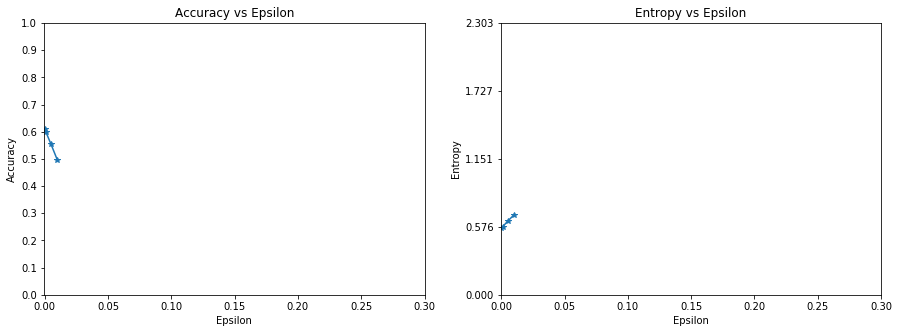

In [30]:
# fig, ax_array = plt.subplots(num_epochs, int(len(var_list)/num_epochs))

fig = plt.figure(figsize=(15,5))
plt.subplots_adjust(hspace=2)

ax = fig.add_subplot(1, 2, 1)
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")

ax = fig.add_subplot(1, 2, 2)
plt.plot(epsilons, entropies, "*-")
plt.yticks(np.linspace(0, max_entropy, 5))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Entropy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Entropy")
plt.show()

# Bayesian Neural Network

In [12]:
bnn = CNN_lrt(10, 3, prior_var='adaptive', prior_var_factor=0.1)
#net= CNN_lrt(10, 3)
#net = resnet18(pretrained=False)

if use_cuda:
    bnn.cuda()

neg_elbo = neg_ELBO(net=bnn)
optimizer = optim.Adam(bnn.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [13]:
bayesian_train_acc = []
bayesian_val_acc = []

for epoch in range(1, num_epochs + 1):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    m_train = math.ceil(len(train_data) / batch_size)
    m_test= math.ceil(len(test_data) / batch_size)

    bnn.train()

    total = 0
    correct = 0

    for batch_idx, (data, target) in zip(tqdm(range(m_train)),(train_loader)):
        # move tensors to GPU if CUDA is available
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        beta = 1
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = bnn(data)

        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        # calculate the batch loss
        loss = neg_elbo(output, target, beta)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += (loss.item() * data.size(0))

    test_correct = 0
    test_total = 0

    with torch.no_grad():
        bnn.eval()
        for i, (test_input, test_target) in zip(tqdm(range(m_test)), test_loader):
        # for (test_data, test_target) in test_loader:
            test_input, test_target = test_input.cuda(), test_target.cuda()
            test_outputs = bnn(test_input)
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_total += test_target.size(0)
            test_correct += (test_predicted == test_target).sum().item()

    train_loss = train_loss / len(train_loader.dataset)

    bayesian_train_acc.append(correct / total)
    bayesian_val_acc.append(test_correct/ test_total)   
        
    
    print('--------------------------------------------------------------')
    print('Epoch:', epoch)
    print('--------------------------------------------------------------')
    print('Trainig loss:', train_loss)
    print('--------------------------------------------------------------')
    print('Accuracy of the network on the train images: {} percent ({}/{})'.format(
            100 * correct / total, correct, total))
    print('--------------------------------------------------------------')
    try:
        print('Accuracy of the network on the test images: {} percent ({}/{})'.format(
                100 * test_correct/ test_total, test_correct,test_total))
        print('--------------------------------------------------------------')
    except:
        pass

  0%|          | 7/3125 [00:00<00:49, 62.57it/s]

--------------------------------------------------------------
Epoch: 1
--------------------------------------------------------------
Trainig loss: 5.079693139305115
--------------------------------------------------------------
Accuracy of the network on the train images: 40.872 percent (20436/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 48.48 percent (303/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:55, 56.12it/s]

--------------------------------------------------------------
Epoch: 2
--------------------------------------------------------------
Trainig loss: 4.961787837066651
--------------------------------------------------------------
Accuracy of the network on the train images: 48.34 percent (24170/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 52.48 percent (328/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:52, 59.35it/s]

--------------------------------------------------------------
Epoch: 3
--------------------------------------------------------------
Trainig loss: 4.86952579498291
--------------------------------------------------------------
Accuracy of the network on the train images: 50.636 percent (25318/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 54.56 percent (341/625)
--------------------------------------------------------------


  0%|          | 7/3125 [00:00<00:44, 69.58it/s]

--------------------------------------------------------------
Epoch: 4
--------------------------------------------------------------
Trainig loss: 4.8038262977600095
--------------------------------------------------------------
Accuracy of the network on the train images: 51.662 percent (25831/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 56.0 percent (350/625)
--------------------------------------------------------------


  0%|          | 7/3125 [00:00<00:47, 65.43it/s]

--------------------------------------------------------------
Epoch: 5
--------------------------------------------------------------
Trainig loss: 4.757041071929931
--------------------------------------------------------------
Accuracy of the network on the train images: 52.796 percent (26398/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 56.48 percent (353/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:54, 57.62it/s]

--------------------------------------------------------------
Epoch: 6
--------------------------------------------------------------
Trainig loss: 4.723942530517578
--------------------------------------------------------------
Accuracy of the network on the train images: 53.89 percent (26945/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.2 percent (345/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:57, 53.95it/s]

--------------------------------------------------------------
Epoch: 7
--------------------------------------------------------------
Trainig loss: 4.6963046433258056
--------------------------------------------------------------
Accuracy of the network on the train images: 54.306 percent (27153/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 56.16 percent (351/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:52, 59.11it/s]

--------------------------------------------------------------
Epoch: 8
--------------------------------------------------------------
Trainig loss: 4.675451813659668
--------------------------------------------------------------
Accuracy of the network on the train images: 54.864 percent (27432/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 55.68 percent (348/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:55, 56.30it/s]

--------------------------------------------------------------
Epoch: 9
--------------------------------------------------------------
Trainig loss: 4.656296084899902
--------------------------------------------------------------
Accuracy of the network on the train images: 55.198 percent (27599/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 56.32 percent (352/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:55, 56.53it/s]

--------------------------------------------------------------
Epoch: 10
--------------------------------------------------------------
Trainig loss: 4.638880387954712
--------------------------------------------------------------
Accuracy of the network on the train images: 55.622 percent (27811/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.72 percent (367/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:58, 53.71it/s]

--------------------------------------------------------------
Epoch: 11
--------------------------------------------------------------
Trainig loss: 4.6230151112365725
--------------------------------------------------------------
Accuracy of the network on the train images: 55.636 percent (27818/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 57.92 percent (362/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:58, 53.39it/s]

--------------------------------------------------------------
Epoch: 12
--------------------------------------------------------------
Trainig loss: 4.611608590621948
--------------------------------------------------------------
Accuracy of the network on the train images: 56.194 percent (28097/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.56 percent (366/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:58, 53.72it/s]

--------------------------------------------------------------
Epoch: 13
--------------------------------------------------------------
Trainig loss: 4.599219848403931
--------------------------------------------------------------
Accuracy of the network on the train images: 56.518 percent (28259/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 57.6 percent (360/625)
--------------------------------------------------------------


  0%|          | 7/3125 [00:00<00:49, 63.51it/s]

--------------------------------------------------------------
Epoch: 14
--------------------------------------------------------------
Trainig loss: 4.589947783432007
--------------------------------------------------------------
Accuracy of the network on the train images: 56.856 percent (28428/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 59.84 percent (374/625)
--------------------------------------------------------------


  0%|          | 7/3125 [00:00<00:49, 63.05it/s]

--------------------------------------------------------------
Epoch: 15
--------------------------------------------------------------
Trainig loss: 4.583043274230957
--------------------------------------------------------------
Accuracy of the network on the train images: 56.804 percent (28402/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 57.92 percent (362/625)
--------------------------------------------------------------


  0%|          | 7/3125 [00:00<00:49, 62.40it/s]

--------------------------------------------------------------
Epoch: 16
--------------------------------------------------------------
Trainig loss: 4.57044669593811
--------------------------------------------------------------
Accuracy of the network on the train images: 57.052 percent (28526/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 59.84 percent (374/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:55, 55.73it/s]

--------------------------------------------------------------
Epoch: 17
--------------------------------------------------------------
Trainig loss: 4.561891494064331
--------------------------------------------------------------
Accuracy of the network on the train images: 56.97 percent (28485/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 57.6 percent (360/625)
--------------------------------------------------------------


  0%|          | 7/3125 [00:00<00:50, 61.63it/s]

--------------------------------------------------------------
Epoch: 18
--------------------------------------------------------------
Trainig loss: 4.553013551940918
--------------------------------------------------------------
Accuracy of the network on the train images: 57.27 percent (28635/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.56 percent (366/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<01:00, 51.75it/s]

--------------------------------------------------------------
Epoch: 19
--------------------------------------------------------------
Trainig loss: 4.5412193386840825
--------------------------------------------------------------
Accuracy of the network on the train images: 57.69 percent (28845/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.24 percent (364/625)
--------------------------------------------------------------


  0%|          | 7/3125 [00:00<00:46, 66.63it/s]

--------------------------------------------------------------
Epoch: 20
--------------------------------------------------------------
Trainig loss: 4.530414970932007
--------------------------------------------------------------
Accuracy of the network on the train images: 57.86 percent (28930/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.88 percent (368/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:53, 58.33it/s]

--------------------------------------------------------------
Epoch: 21
--------------------------------------------------------------
Trainig loss: 4.526420365829468
--------------------------------------------------------------
Accuracy of the network on the train images: 57.78 percent (28890/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 59.2 percent (370/625)
--------------------------------------------------------------


  0%|          | 7/3125 [00:00<00:47, 66.12it/s]

--------------------------------------------------------------
Epoch: 22
--------------------------------------------------------------
Trainig loss: 4.521435641326904
--------------------------------------------------------------
Accuracy of the network on the train images: 57.734 percent (28867/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 59.52 percent (372/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:54, 57.45it/s]

--------------------------------------------------------------
Epoch: 23
--------------------------------------------------------------
Trainig loss: 4.5159298894500735
--------------------------------------------------------------
Accuracy of the network on the train images: 57.826 percent (28913/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.72 percent (367/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:52, 59.20it/s]

--------------------------------------------------------------
Epoch: 24
--------------------------------------------------------------
Trainig loss: 4.511155044708252
--------------------------------------------------------------
Accuracy of the network on the train images: 58.248 percent (29124/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.32 percent (377/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:58, 53.14it/s]

--------------------------------------------------------------
Epoch: 25
--------------------------------------------------------------
Trainig loss: 4.507766104049683
--------------------------------------------------------------
Accuracy of the network on the train images: 58.086 percent (29043/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 57.92 percent (362/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:58, 53.72it/s]

--------------------------------------------------------------
Epoch: 26
--------------------------------------------------------------
Trainig loss: 4.505819231948853
--------------------------------------------------------------
Accuracy of the network on the train images: 58.4 percent (29200/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 56.96 percent (356/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:56, 55.35it/s]

--------------------------------------------------------------
Epoch: 27
--------------------------------------------------------------
Trainig loss: 4.506489484786988
--------------------------------------------------------------
Accuracy of the network on the train images: 57.902 percent (28951/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.72 percent (367/625)
--------------------------------------------------------------


  0%|          | 5/3125 [00:00<01:04, 48.07it/s]

--------------------------------------------------------------
Epoch: 28
--------------------------------------------------------------
Trainig loss: 4.499847924423218
--------------------------------------------------------------
Accuracy of the network on the train images: 58.258 percent (29129/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 59.52 percent (372/625)
--------------------------------------------------------------


  0%|          | 5/3125 [00:00<01:07, 45.92it/s]

--------------------------------------------------------------
Epoch: 29
--------------------------------------------------------------
Trainig loss: 4.49764683128357
--------------------------------------------------------------
Accuracy of the network on the train images: 58.404 percent (29202/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 61.44 percent (384/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:59, 52.42it/s]

--------------------------------------------------------------
Epoch: 30
--------------------------------------------------------------
Trainig loss: 4.492816765365601
--------------------------------------------------------------
Accuracy of the network on the train images: 58.424 percent (29212/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 57.28 percent (358/625)
--------------------------------------------------------------


  0%|          | 7/3125 [00:00<00:50, 61.60it/s]

--------------------------------------------------------------
Epoch: 31
--------------------------------------------------------------
Trainig loss: 4.490201493911743
--------------------------------------------------------------
Accuracy of the network on the train images: 58.418 percent (29209/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 61.12 percent (382/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<01:02, 49.69it/s]

--------------------------------------------------------------
Epoch: 32
--------------------------------------------------------------
Trainig loss: 4.48553944984436
--------------------------------------------------------------
Accuracy of the network on the train images: 58.376 percent (29188/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.0 percent (375/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:55, 56.55it/s]

--------------------------------------------------------------
Epoch: 33
--------------------------------------------------------------
Trainig loss: 4.4822040182495115
--------------------------------------------------------------
Accuracy of the network on the train images: 58.646 percent (29323/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 59.04 percent (369/625)
--------------------------------------------------------------


  0%|          | 7/3125 [00:00<00:48, 63.64it/s]

--------------------------------------------------------------
Epoch: 34
--------------------------------------------------------------
Trainig loss: 4.478851832809449
--------------------------------------------------------------
Accuracy of the network on the train images: 58.878 percent (29439/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 57.92 percent (362/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<01:01, 50.95it/s]

--------------------------------------------------------------
Epoch: 35
--------------------------------------------------------------
Trainig loss: 4.480361018981934
--------------------------------------------------------------
Accuracy of the network on the train images: 58.812 percent (29406/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.24 percent (364/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:52, 59.27it/s]

--------------------------------------------------------------
Epoch: 36
--------------------------------------------------------------
Trainig loss: 4.478685247116089
--------------------------------------------------------------
Accuracy of the network on the train images: 58.752 percent (29376/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 59.68 percent (373/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:54, 57.50it/s]

--------------------------------------------------------------
Epoch: 37
--------------------------------------------------------------
Trainig loss: 4.474318340454102
--------------------------------------------------------------
Accuracy of the network on the train images: 58.584 percent (29292/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 62.56 percent (391/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:55, 56.03it/s]

--------------------------------------------------------------
Epoch: 38
--------------------------------------------------------------
Trainig loss: 4.472860015945434
--------------------------------------------------------------
Accuracy of the network on the train images: 58.992 percent (29496/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.56 percent (366/625)
--------------------------------------------------------------


  0%|          | 5/3125 [00:00<01:04, 48.63it/s]

--------------------------------------------------------------
Epoch: 39
--------------------------------------------------------------
Trainig loss: 4.475539966049194
--------------------------------------------------------------
Accuracy of the network on the train images: 59.118 percent (29559/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 61.28 percent (383/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:53, 58.17it/s]

--------------------------------------------------------------
Epoch: 40
--------------------------------------------------------------
Trainig loss: 4.471067373199463
--------------------------------------------------------------
Accuracy of the network on the train images: 59.132 percent (29566/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.4 percent (365/625)
--------------------------------------------------------------


  0%|          | 7/3125 [00:00<00:47, 65.23it/s]

--------------------------------------------------------------
Epoch: 41
--------------------------------------------------------------
Trainig loss: 4.472743715209961
--------------------------------------------------------------
Accuracy of the network on the train images: 58.966 percent (29483/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.16 percent (376/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:59, 52.06it/s]

--------------------------------------------------------------
Epoch: 42
--------------------------------------------------------------
Trainig loss: 4.469188052825928
--------------------------------------------------------------
Accuracy of the network on the train images: 59.028 percent (29514/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 62.08 percent (388/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:56, 55.14it/s]

--------------------------------------------------------------
Epoch: 43
--------------------------------------------------------------
Trainig loss: 4.466092801361084
--------------------------------------------------------------
Accuracy of the network on the train images: 59.274 percent (29637/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 59.36 percent (371/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:54, 57.01it/s]

--------------------------------------------------------------
Epoch: 44
--------------------------------------------------------------
Trainig loss: 4.466685050048828
--------------------------------------------------------------
Accuracy of the network on the train images: 59.208 percent (29604/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 61.6 percent (385/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:56, 55.38it/s]

--------------------------------------------------------------
Epoch: 45
--------------------------------------------------------------
Trainig loss: 4.470104494934082
--------------------------------------------------------------
Accuracy of the network on the train images: 58.912 percent (29456/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 59.68 percent (373/625)
--------------------------------------------------------------


  0%|          | 7/3125 [00:00<00:46, 66.83it/s]

--------------------------------------------------------------
Epoch: 46
--------------------------------------------------------------
Trainig loss: 4.472246787872314
--------------------------------------------------------------
Accuracy of the network on the train images: 59.092 percent (29546/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.16 percent (376/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:54, 57.07it/s]

--------------------------------------------------------------
Epoch: 47
--------------------------------------------------------------
Trainig loss: 4.469401614456177
--------------------------------------------------------------
Accuracy of the network on the train images: 59.072 percent (29536/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 61.28 percent (383/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:54, 57.61it/s]

--------------------------------------------------------------
Epoch: 48
--------------------------------------------------------------
Trainig loss: 4.471884975204468
--------------------------------------------------------------
Accuracy of the network on the train images: 59.192 percent (29596/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.4 percent (365/625)
--------------------------------------------------------------


  0%|          | 7/3125 [00:00<00:47, 66.21it/s]

--------------------------------------------------------------
Epoch: 49
--------------------------------------------------------------
Trainig loss: 4.46783459098816
--------------------------------------------------------------
Accuracy of the network on the train images: 59.416 percent (29708/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.96 percent (381/625)
--------------------------------------------------------------


  0%|          | 7/3125 [00:00<00:52, 59.71it/s]

--------------------------------------------------------------
Epoch: 50
--------------------------------------------------------------
Trainig loss: 4.468274758834839
--------------------------------------------------------------
Accuracy of the network on the train images: 59.312 percent (29656/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.64 percent (379/625)
--------------------------------------------------------------


  0%|          | 7/3125 [00:00<00:46, 67.17it/s]

--------------------------------------------------------------
Epoch: 51
--------------------------------------------------------------
Trainig loss: 4.464874960784912
--------------------------------------------------------------
Accuracy of the network on the train images: 59.288 percent (29644/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 59.68 percent (373/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:52, 59.49it/s]

--------------------------------------------------------------
Epoch: 52
--------------------------------------------------------------
Trainig loss: 4.463615839157105
--------------------------------------------------------------
Accuracy of the network on the train images: 59.234 percent (29617/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.32 percent (377/625)
--------------------------------------------------------------


  0%|          | 7/3125 [00:00<00:50, 61.97it/s]

--------------------------------------------------------------
Epoch: 53
--------------------------------------------------------------
Trainig loss: 4.465508531799316
--------------------------------------------------------------
Accuracy of the network on the train images: 59.484 percent (29742/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.88 percent (368/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:53, 58.07it/s]

--------------------------------------------------------------
Epoch: 54
--------------------------------------------------------------
Trainig loss: 4.4617599747467045
--------------------------------------------------------------
Accuracy of the network on the train images: 59.216 percent (29608/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 57.6 percent (360/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:59, 52.58it/s]

--------------------------------------------------------------
Epoch: 55
--------------------------------------------------------------
Trainig loss: 4.462319760971069
--------------------------------------------------------------
Accuracy of the network on the train images: 59.256 percent (29628/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 61.28 percent (383/625)
--------------------------------------------------------------


  0%|          | 7/3125 [00:00<00:47, 65.69it/s]

--------------------------------------------------------------
Epoch: 56
--------------------------------------------------------------
Trainig loss: 4.461689300308228
--------------------------------------------------------------
Accuracy of the network on the train images: 59.302 percent (29651/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 61.76 percent (386/625)
--------------------------------------------------------------


  0%|          | 7/3125 [00:00<00:50, 61.33it/s]

--------------------------------------------------------------
Epoch: 57
--------------------------------------------------------------
Trainig loss: 4.458483860321045
--------------------------------------------------------------
Accuracy of the network on the train images: 59.344 percent (29672/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.32 percent (377/625)
--------------------------------------------------------------


  0%|          | 7/3125 [00:00<00:47, 65.89it/s]

--------------------------------------------------------------
Epoch: 58
--------------------------------------------------------------
Trainig loss: 4.457031405944824
--------------------------------------------------------------
Accuracy of the network on the train images: 59.69 percent (29845/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.64 percent (379/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:59, 52.32it/s]

--------------------------------------------------------------
Epoch: 59
--------------------------------------------------------------
Trainig loss: 4.457091675720215
--------------------------------------------------------------
Accuracy of the network on the train images: 59.262 percent (29631/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.32 percent (377/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:54, 57.28it/s]

--------------------------------------------------------------
Epoch: 60
--------------------------------------------------------------
Trainig loss: 4.456251717834473
--------------------------------------------------------------
Accuracy of the network on the train images: 59.554 percent (29777/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 61.76 percent (386/625)
--------------------------------------------------------------


  0%|          | 7/3125 [00:00<00:51, 60.36it/s]

--------------------------------------------------------------
Epoch: 61
--------------------------------------------------------------
Trainig loss: 4.4578470627594
--------------------------------------------------------------
Accuracy of the network on the train images: 59.674 percent (29837/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.64 percent (379/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:54, 57.40it/s]

--------------------------------------------------------------
Epoch: 62
--------------------------------------------------------------
Trainig loss: 4.459351893920898
--------------------------------------------------------------
Accuracy of the network on the train images: 59.46 percent (29730/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 59.2 percent (370/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:54, 57.14it/s]

--------------------------------------------------------------
Epoch: 63
--------------------------------------------------------------
Trainig loss: 4.463624753112793
--------------------------------------------------------------
Accuracy of the network on the train images: 59.344 percent (29672/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.96 percent (381/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:56, 55.58it/s]

--------------------------------------------------------------
Epoch: 64
--------------------------------------------------------------
Trainig loss: 4.460278659515381
--------------------------------------------------------------
Accuracy of the network on the train images: 59.61 percent (29805/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 62.08 percent (388/625)
--------------------------------------------------------------


  0%|          | 7/3125 [00:00<00:47, 64.98it/s]

--------------------------------------------------------------
Epoch: 65
--------------------------------------------------------------
Trainig loss: 4.457393229064942
--------------------------------------------------------------
Accuracy of the network on the train images: 59.604 percent (29802/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 62.4 percent (390/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:58, 53.48it/s]

--------------------------------------------------------------
Epoch: 66
--------------------------------------------------------------
Trainig loss: 4.449056984558106
--------------------------------------------------------------
Accuracy of the network on the train images: 59.688 percent (29844/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 59.2 percent (370/625)
--------------------------------------------------------------


  0%|          | 5/3125 [00:00<01:12, 43.05it/s]

--------------------------------------------------------------
Epoch: 67
--------------------------------------------------------------
Trainig loss: 4.453869697494507
--------------------------------------------------------------
Accuracy of the network on the train images: 59.57 percent (29785/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 59.04 percent (369/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:52, 58.87it/s]

--------------------------------------------------------------
Epoch: 68
--------------------------------------------------------------
Trainig loss: 4.453297398757934
--------------------------------------------------------------
Accuracy of the network on the train images: 59.844 percent (29922/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 57.12 percent (357/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:59, 52.12it/s]

--------------------------------------------------------------
Epoch: 69
--------------------------------------------------------------
Trainig loss: 4.453436958770752
--------------------------------------------------------------
Accuracy of the network on the train images: 59.56 percent (29780/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.48 percent (378/625)
--------------------------------------------------------------


  0%|          | 5/3125 [00:00<01:04, 48.52it/s]

--------------------------------------------------------------
Epoch: 70
--------------------------------------------------------------
Trainig loss: 4.452393629302978
--------------------------------------------------------------
Accuracy of the network on the train images: 59.586 percent (29793/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.64 percent (379/625)
--------------------------------------------------------------


  0%|          | 5/3125 [00:00<01:04, 48.10it/s]

--------------------------------------------------------------
Epoch: 71
--------------------------------------------------------------
Trainig loss: 4.452264652786255
--------------------------------------------------------------
Accuracy of the network on the train images: 59.354 percent (29677/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 57.92 percent (362/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:57, 53.86it/s]

--------------------------------------------------------------
Epoch: 72
--------------------------------------------------------------
Trainig loss: 4.450085944366455
--------------------------------------------------------------
Accuracy of the network on the train images: 59.562 percent (29781/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.0 percent (375/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:58, 53.74it/s]

--------------------------------------------------------------
Epoch: 73
--------------------------------------------------------------
Trainig loss: 4.447520790176392
--------------------------------------------------------------
Accuracy of the network on the train images: 59.654 percent (29827/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.56 percent (366/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:58, 53.24it/s]

--------------------------------------------------------------
Epoch: 74
--------------------------------------------------------------
Trainig loss: 4.446537017593384
--------------------------------------------------------------
Accuracy of the network on the train images: 59.544 percent (29772/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 59.68 percent (373/625)
--------------------------------------------------------------


  0%|          | 7/3125 [00:00<00:47, 65.32it/s]

--------------------------------------------------------------
Epoch: 75
--------------------------------------------------------------
Trainig loss: 4.447810096206665
--------------------------------------------------------------
Accuracy of the network on the train images: 59.482 percent (29741/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 58.24 percent (364/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:54, 56.84it/s]

--------------------------------------------------------------
Epoch: 76
--------------------------------------------------------------
Trainig loss: 4.445104792556763
--------------------------------------------------------------
Accuracy of the network on the train images: 59.636 percent (29818/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 61.6 percent (385/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<01:00, 51.58it/s]

--------------------------------------------------------------
Epoch: 77
--------------------------------------------------------------
Trainig loss: 4.443075377197266
--------------------------------------------------------------
Accuracy of the network on the train images: 59.724 percent (29862/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 59.68 percent (373/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:59, 52.85it/s]

--------------------------------------------------------------
Epoch: 78
--------------------------------------------------------------
Trainig loss: 4.443938307800293
--------------------------------------------------------------
Accuracy of the network on the train images: 59.664 percent (29832/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 62.4 percent (390/625)
--------------------------------------------------------------


  0%|          | 6/3125 [00:00<00:56, 55.29it/s]

--------------------------------------------------------------
Epoch: 79
--------------------------------------------------------------
Trainig loss: 4.443424372558594
--------------------------------------------------------------
Accuracy of the network on the train images: 59.84 percent (29920/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 60.8 percent (380/625)
--------------------------------------------------------------


100%|██████████| 625/625 [00:01<00:00, 470.52it/s]

--------------------------------------------------------------
Epoch: 80
--------------------------------------------------------------
Trainig loss: 4.449116049118042
--------------------------------------------------------------
Accuracy of the network on the train images: 59.368 percent (29684/50000)
--------------------------------------------------------------
Accuracy of the network on the test images: 62.4 percent (390/625)
--------------------------------------------------------------


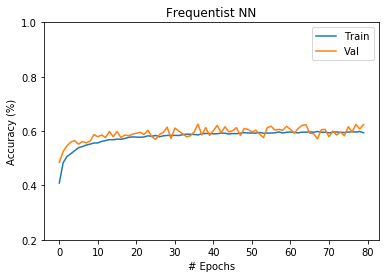

In [19]:
f = plt.figure(0)
plt.plot(range(len(bayesian_train_acc)),bayesian_train_acc)
plt.plot(range(len(bayesian_val_acc)),bayesian_val_acc)
plt.title('BNN')
plt.xlabel('# Epochs')
plt.ylabel('Accuracy (%)')
plt.ylim(0.2,1)
plt.yticks((np.arange(0.2,1.01,0.2)))

plt.legend(('Train','Val'))
f.savefig('freq_acc.pdf')

In [16]:
entropies = []
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
epsilons = [.05, .1, .15, .2, .25, .3]
#epsilons = [0, .001, .005, .01]
num_samples = 10

# Run test for each epsilon
for eps in epsilons:
    entropy, max_entropy = entropy_vs_eps(bnn, device, test_loader, eps, num_samples)
    entropies.append(entropy)
    
ax = fig.add_subplot()
plt.plot(epsilons, entropies, "*-")
plt.yticks(np.linspace(0, max_entropy, 5))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Entropy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Entropy")
plt.show()

  0%|          | 4/10000 [00:00<04:38, 35.91it/s]

Epsilon: 0.05	Entropy = 1.2746459245681763


  0%|          | 4/10000 [00:00<04:30, 36.89it/s]

Epsilon: 0.1	Entropy = 1.3682372570037842


  0%|          | 4/10000 [00:00<04:25, 37.66it/s]

Epsilon: 0.15	Entropy = 1.3390986919403076


  0%|          | 5/10000 [00:00<04:10, 39.96it/s]

Epsilon: 0.2	Entropy = 1.2525408267974854


  1%|▏         | 135/10000 [00:03<04:30, 36.44it/s]


KeyboardInterrupt: 

In [15]:
accuracies = []
examples = []
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
epsilons = [.05, .1, .15, .2, .25, .3]
#epsilons = [0, .001, .005, .01]

# Run test for each epsilon
for eps in epsilons:
    acc, ex = acc_vs_eps(bnn, device, test_loader, eps)
    accuracies.append(accuracies)
    examples.append(ex)
    
ax = fig.add_subplot()
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

NameError: name 'device' is not defined

In [ ]:
# fig, ax_array = plt.subplots(num_epochs, int(len(var_list)/num_epochs))

fig = plt.figure(figsize=(15,5))
plt.subplots_adjust(hspace=2)

ax = fig.add_subplot(1, 2, 1)
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")

ax = fig.add_subplot(1, 2, 2)
plt.plot(epsilons, entropies, "*-")
plt.yticks(np.linspace(0, max_entropy, 5))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Entropy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Entropy")
plt.show()

In [ ]:
a = np.array((0.3,0.4,0.2,0.1))
b= np.array((0.25,0.25,0.25,0.25))
c = np.array((1,0,0,0))
d = np.vstack((a,b,c))

for i in [a,b,c,d]:
    try:
        print(-torch.sum(i * np.log(1e-16 + i), 1))
    except:
        print(-torch.sum(i * np.log(1e-16 + i)))